In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import csv
import pickle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **Data Loading**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ***Information***
Attribute Information.
  1.  Sequence Name: Accession number for the SWISS-PROT database
  2.  mcg: McGeoch's method for signal sequence recognition.
  3.  gvh: von Heijne's method for signal sequence recognition.
  4.  alm: Score of the ALOM membrane spanning region prediction program.
  5.  mit: Score of discriminant analysis of the amino acid content of
	   the N-terminal region (20 residues long) of mitochondrial and 
           non-mitochondrial proteins.
  6.  erl: Presence of "HDEL" substring (thought to act as a signal for
	   retention in the endoplasmic reticulum lumen). Binary attribute.
  7.  pox: Peroxisomal targeting signal in the C-terminus.
  8.  vac: Score of discriminant analysis of the amino acid content of
           vacuolar and extracellular proteins.
  9.  nuc: Score of discriminant analysis of nuclear localization signals
	   of nuclear and non-nuclear proteins.


Class Distribution. The class is the localization site. Please see Nakai &
Kanehisa referenced above for more details.
  

  1.  CYT (cytosolic or cytoskeletal)                    463
  2.  NUC (nuclear)                                      429
  3.  MIT (mitochondrial)                                244
  4.  ME3 (membrane protein, no N-terminal signal)       163
  5.  ME2 (membrane protein, uncleaved signal)            51
  6.  ME1 (membrane protein, cleaved signal)              44
  7.  EXC (extracellular)                                 37
  8.  VAC (vacuolar)                                      30
  9.  POX (peroxisomal)                                   20
  10. ERL (endoplasmic reticulum lumen)                    5



In [86]:
dataSet = 'yeast_05679_4'
filePath = '/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/'+dataSet+'.csv'
data = pd.read_csv(filePath)
data

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT
...,...,...,...,...,...,...,...,...,...
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,ME2
1480,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1481,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,ME2
1482,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC


In [87]:
data.groupby('name').count()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
name,,,,,,,,
CYT,463,463,463,463,463,463,463,463
ERL,5,5,5,5,5,5,5,5
EXC,35,35,35,35,35,35,35,35
ME1,44,44,44,44,44,44,44,44
ME2,51,51,51,51,51,51,51,51
ME3,163,163,163,163,163,163,163,163
MIT,244,244,244,244,244,244,244,244
NUC,429,429,429,429,429,429,429,429
POX,20,20,20,20,20,20,20,20


In [88]:
data = data.replace(np.nan,0.0)

In [89]:
data.iloc[3,3]

0.13

In [90]:
#_05679_4
for i in range(len(data)):
  if data.iloc[i,8]=='ME2':
    data.iloc[i,8] = 1.0
  elif data.iloc[i,8]=='ERL' or data.iloc[i,8]=='EXC' or data.iloc[i,8]=='ME3' or data.iloc[i,8]=='MIT' or data.iloc[i,8]=='VAC':
    data.iloc[i,8] = 0.0
  # else:
  #   data = data.drop(data.index[i],inplace=True)
data

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,0.0
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,0.0
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,0.0
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,0.0
...,...,...,...,...,...,...,...,...,...
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,1.0
1480,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1481,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,1.0
1482,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC


In [91]:
#Converting list to csv file
d = []
for i in range(len(data)):
  if data.iloc[i,8]==0.0 or data.iloc[i,8]==1.0:
    d.append(data.iloc[i])

d = pd.DataFrame(d)  
d.to_csv('d.csv') 
data = d
data

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,0.0
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,0.0
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,0.0
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,0.0
6,0.50,0.54,0.48,0.65,0.5,0.0,0.53,0.22,0.0
...,...,...,...,...,...,...,...,...,...
1469,0.38,0.47,0.47,0.18,0.5,0.0,0.44,0.26,0.0
1470,0.63,0.57,0.50,0.48,0.5,0.0,0.51,0.22,0.0
1471,0.51,0.45,0.62,0.25,0.5,0.0,0.59,0.22,0.0
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,1.0


In [92]:
from random import shuffle
train, test= train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
print(train.shape,test.shape)

(422, 9) (106, 9)


In [93]:
train.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
1470,0.63,0.57,0.50,0.48,0.5,0.0,0.51,0.22,0.0
433,0.38,0.46,0.52,0.75,0.5,0.0,0.50,0.26,0.0
869,0.57,0.60,0.54,0.17,0.5,0.0,0.52,0.22,0.0
168,0.39,0.42,0.38,0.40,0.5,0.0,0.49,0.47,0.0
867,0.49,0.45,0.54,0.40,0.5,0.0,0.55,0.22,0.0


In [94]:
features = train.columns[0:-1]
features

Index(['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc'], dtype='object')

In [95]:
X = data[features]
y = data['name']
X

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22
6,0.50,0.54,0.48,0.65,0.5,0.0,0.53,0.22
...,...,...,...,...,...,...,...,...
1469,0.38,0.47,0.47,0.18,0.5,0.0,0.44,0.26
1470,0.63,0.57,0.50,0.48,0.5,0.0,0.51,0.22
1471,0.51,0.45,0.62,0.25,0.5,0.0,0.59,0.22
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22


# **Data Split (Major and Minor)**

In [96]:
for(name), group in train.groupby(['name']):
  group.to_csv(f'{name}.csv', index=False)
# print(pd.read_csv("0.0.csv"))
# print(pd.read_csv("1.0.csv"))
train_zero = pd.read_csv("0.0.csv")
train_one = pd.read_csv("1.0.csv")
train_zero

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.63,0.57,0.50,0.48,0.5,0.0,0.51,0.22,0.0
1,0.38,0.46,0.52,0.75,0.5,0.0,0.50,0.26,0.0
2,0.57,0.60,0.54,0.17,0.5,0.0,0.52,0.22,0.0
3,0.39,0.42,0.38,0.40,0.5,0.0,0.49,0.47,0.0
4,0.49,0.45,0.54,0.40,0.5,0.0,0.55,0.22,0.0
...,...,...,...,...,...,...,...,...,...
373,0.38,0.68,0.44,0.45,0.5,0.0,0.53,0.22,0.0
374,0.42,0.57,0.72,0.22,0.5,0.0,0.57,0.22,0.0
375,0.62,0.59,0.54,0.47,0.5,0.0,0.46,0.22,0.0
376,0.75,0.76,0.58,0.22,0.5,0.0,0.49,0.22,0.0


In [97]:
train_one

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.63,0.71,0.44,0.53,0.5,0.0,0.52,0.22,1.0
1,0.34,0.38,0.45,0.19,0.5,0.0,0.51,0.22,1.0
2,0.54,0.42,0.41,0.16,0.5,0.0,0.52,0.22,1.0
3,0.79,0.57,0.41,0.28,0.5,0.0,0.59,0.22,1.0
4,0.94,0.60,0.33,0.49,0.5,0.0,0.54,0.22,1.0
5,0.69,0.57,0.39,0.19,0.5,0.0,0.48,0.39,1.0
6,0.86,0.74,0.51,0.40,0.5,0.0,0.55,0.22,1.0
7,0.83,0.53,0.52,0.20,0.5,0.0,0.48,0.25,1.0
8,0.36,0.34,0.46,0.19,0.5,0.0,0.52,0.22,1.0
9,0.71,0.51,0.49,0.23,0.5,0.0,0.30,0.32,1.0


In [98]:
train_zero.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/train_zero.csv')
train_one.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/train_one.csv')


In [99]:
major_class = train_zero
minor_class = train_one

In [100]:
# before scaling the min and max values for both alcohol and malic acid are different 

minor_class.describe().T  


,count,mean,std,min,25%,50%,75%,max
mcg,44.0,0.731591,0.155278,0.34,0.6825,0.760,0.8300,0.97
gvh,44.0,0.612955,0.119972,0.34,0.5450,0.595,0.7100,0.90
alm,44.0,0.417273,0.079749,0.27,0.3650,0.410,0.4525,0.60
mit,44.0,0.293636,0.128499,0.04,0.1900,0.270,0.3750,0.57
erl,44.0,0.511364,0.075378,0.50,0.5000,0.500,0.5000,1.00
pox,44.0,0.000000,0.000000,0.00,0.0000,0.000,0.0000,0.00
vac,44.0,0.503864,0.061122,0.30,0.5000,0.520,0.5400,0.59
nuc,44.0,0.246136,0.053926,0.22,0.2200,0.220,0.2500,0.47
name,44.0,1.000000,0.000000,1.00,1.0000,1.000,1.0000,1.00


In [101]:
major_class.describe().T

,count,mean,std,min,25%,50%,75%,max
mcg,378.0,0.512169,0.128823,0.20,0.4225,0.50,0.5875,0.89
gvh,378.0,0.534815,0.125947,0.14,0.4500,0.53,0.6100,1.00
alm,378.0,0.459656,0.098797,0.21,0.3800,0.47,0.5300,0.72
mit,378.0,0.321931,0.160271,0.08,0.1825,0.28,0.4400,0.82
erl,378.0,0.507937,0.062575,0.50,0.5000,0.50,0.5000,1.00
pox,378.0,0.003519,0.049780,0.00,0.0000,0.00,0.0000,0.83
vac,378.0,0.503624,0.048037,0.27,0.4800,0.51,0.5300,0.69
nuc,378.0,0.249868,0.066054,0.11,0.2200,0.22,0.2600,0.66
name,378.0,0.000000,0.000000,0.00,0.0000,0.00,0.0000,0.00


In [102]:
n = len(data.iloc[0])
n

9

# **Auto Encoder**

In [103]:
import keras
from keras import layers

# This is the size of our encoded representations
n = len(data.iloc[0]) - 1
encoding_dim = n # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(n,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation=None)(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(n, activation=None)(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [104]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


In [105]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [106]:
autoencoder.compile(optimizer='adam', loss='mse')

In [107]:
x_train = minor_class[features]
x_test = major_class[features]
y_train = minor_class['name']
y_test = major_class['name']

# **Data Scaling**

In [108]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()    # create an object of class

scaler.fit(x_train)       #  fit on training i/p data
x_train_scaled = scaler.transform(x_train)    # transform model on both traing and testing data

scaler.fit(x_test)
x_test_scaled = scaler.transform(x_test)


In [109]:
# convert the numpy array after transform into a dataframe
x_train_scaled = pd.DataFrame(x_train_scaled,columns = x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled,columns = x_test.columns)
#x_test_scaled = pd.DataFrame(x_test_scaled,columns = x_test.columns)


In [110]:
x_train.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/x_train.csv')
x_test.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/x_test.csv')
x_train_scaled.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/x_train_scaled.csv')
x_test_scaled.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/x_test_scaled.csv')


In [111]:
x_train.shape

(44, 8)

In [112]:
x_test.shape

(378, 8)

In [113]:
x_train

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.63,0.71,0.44,0.53,0.5,0.0,0.52,0.22
1,0.34,0.38,0.45,0.19,0.5,0.0,0.51,0.22
2,0.54,0.42,0.41,0.16,0.5,0.0,0.52,0.22
3,0.79,0.57,0.41,0.28,0.5,0.0,0.59,0.22
4,0.94,0.60,0.33,0.49,0.5,0.0,0.54,0.22
5,0.69,0.57,0.39,0.19,0.5,0.0,0.48,0.39
6,0.86,0.74,0.51,0.40,0.5,0.0,0.55,0.22
7,0.83,0.53,0.52,0.20,0.5,0.0,0.48,0.25
8,0.36,0.34,0.46,0.19,0.5,0.0,0.52,0.22
9,0.71,0.51,0.49,0.23,0.5,0.0,0.30,0.32


In [114]:
x_test

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.63,0.57,0.50,0.48,0.5,0.0,0.51,0.22
1,0.38,0.46,0.52,0.75,0.5,0.0,0.50,0.26
2,0.57,0.60,0.54,0.17,0.5,0.0,0.52,0.22
3,0.39,0.42,0.38,0.40,0.5,0.0,0.49,0.47
4,0.49,0.45,0.54,0.40,0.5,0.0,0.55,0.22
...,...,...,...,...,...,...,...,...
373,0.38,0.68,0.44,0.45,0.5,0.0,0.53,0.22
374,0.42,0.57,0.72,0.22,0.5,0.0,0.57,0.22
375,0.62,0.59,0.54,0.47,0.5,0.0,0.46,0.22
376,0.75,0.76,0.58,0.22,0.5,0.0,0.49,0.22


In [115]:
x_train_scaled

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.460317,0.660714,0.515152,0.924528,0.0,0.0,0.758621,0.00
1,0.000000,0.071429,0.545455,0.283019,0.0,0.0,0.724138,0.00
2,0.317460,0.142857,0.424242,0.226415,0.0,0.0,0.758621,0.00
3,0.714286,0.410714,0.424242,0.452830,0.0,0.0,1.000000,0.00
4,0.952381,0.464286,0.181818,0.849057,0.0,0.0,0.827586,0.00
5,0.555556,0.410714,0.363636,0.283019,0.0,0.0,0.620690,0.68
6,0.825397,0.714286,0.727273,0.679245,0.0,0.0,0.862069,0.00
7,0.777778,0.339286,0.757576,0.301887,0.0,0.0,0.620690,0.12
8,0.031746,0.000000,0.575758,0.283019,0.0,0.0,0.758621,0.00
9,0.587302,0.303571,0.666667,0.358491,0.0,0.0,0.000000,0.40


In [116]:
x_test_scaled

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.623188,0.500000,0.568627,0.540541,0.0,0.0,0.571429,0.200000
1,0.260870,0.372093,0.607843,0.905405,0.0,0.0,0.547619,0.272727
2,0.536232,0.534884,0.647059,0.121622,0.0,0.0,0.595238,0.200000
3,0.275362,0.325581,0.333333,0.432432,0.0,0.0,0.523810,0.654545
4,0.420290,0.360465,0.647059,0.432432,0.0,0.0,0.666667,0.200000
...,...,...,...,...,...,...,...,...
373,0.260870,0.627907,0.450980,0.500000,0.0,0.0,0.619048,0.200000
374,0.318841,0.500000,1.000000,0.189189,0.0,0.0,0.714286,0.200000
375,0.608696,0.523256,0.647059,0.527027,0.0,0.0,0.452381,0.200000
376,0.797101,0.720930,0.725490,0.189189,0.0,0.0,0.523810,0.200000


In [117]:
autoencoder.fit(x_train_scaled, x_train_scaled,
                epochs=50,
                batch_size=8,
                shuffle=True,
                validation_data=(x_train_scaled, x_train_scaled))

Epoch 1/50
6/6 [==============================] - 1s 31ms/step - loss: 0.3127 - val_loss: 0.2864
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 0.2727 - val_loss: 0.2501
Epoch 3/50
6/6 [==============================] - 0s 8ms/step - loss: 0.2374 - val_loss: 0.2185
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 0.2079 - val_loss: 0.1908
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.1818 - val_loss: 0.1668
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.1591 - val_loss: 0.1461
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 0.1386 - val_loss: 0.1286
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 0.1228 - val_loss: 0.1133
Epoch 9/50
6/6 [==============================] - 0s 10ms/step - loss: 0.1081 - val_loss: 0.1006
Epoch 10/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0958 - val_loss: 0.0897
Epoch 11/50
6/6 [==================

In [118]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test_scaled)
#decoded_imgs = decoder.predict(encoded_imgs)
encoded_imgs

12/12 [==============================] - 0s 1ms/step


array([[ 0.43456104,  0.505257  ,  0.35959637, ..., -0.4256875 ,
         0.13811773, -0.1417063 ],
       [ 0.49871176,  0.27939007, -0.06701417, ..., -0.34129956,
         0.22289006,  0.07630171],
       [ 0.49640766,  0.4524298 ,  0.5325518 , ..., -0.485125  ,
         0.0715569 , -0.42505464],
       ...,
       [ 0.38952366,  0.5239661 ,  0.31702417, ..., -0.38987103,
         0.07984581, -0.14697601],
       [ 0.44181004,  0.6773888 ,  0.6706908 , ..., -0.50464374,
         0.0038708 , -0.44956776],
       [ 0.45647106,  0.36338744,  0.32627124, ..., -0.41663444,
         0.13571058, -0.21769744]], dtype=float32)

# **Euclidean Distance**

In [119]:
x_test_scaled_euclidean = x_test_scaled
x_test_scaled_euclidean.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/x_test_scaled_euclidean.csv')
x_test_scaled_euclidean

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.623188,0.500000,0.568627,0.540541,0.0,0.0,0.571429,0.200000
1,0.260870,0.372093,0.607843,0.905405,0.0,0.0,0.547619,0.272727
2,0.536232,0.534884,0.647059,0.121622,0.0,0.0,0.595238,0.200000
3,0.275362,0.325581,0.333333,0.432432,0.0,0.0,0.523810,0.654545
4,0.420290,0.360465,0.647059,0.432432,0.0,0.0,0.666667,0.200000
...,...,...,...,...,...,...,...,...
373,0.260870,0.627907,0.450980,0.500000,0.0,0.0,0.619048,0.200000
374,0.318841,0.500000,1.000000,0.189189,0.0,0.0,0.714286,0.200000
375,0.608696,0.523256,0.647059,0.527027,0.0,0.0,0.452381,0.200000
376,0.797101,0.720930,0.725490,0.189189,0.0,0.0,0.523810,0.200000


In [120]:
new_col = []
#print(len(x_test_scaled.iloc[0]))
for i in range(len(x_test_scaled)):
  tot = 0
  for j in range(len(x_test_scaled.iloc[i])):
    a = (x_test_scaled.iloc[i,j] - encoded_imgs[i][j])*(x_test_scaled.iloc[i,j] - encoded_imgs[i][j])
    tot = tot + a
  new_col.append(tot)
#print(len(new_col))
new_col

[0.5852256097990679,
 1.0681164602200932,
 1.0089097267919611,
 1.661381656971567,
 0.730273134195392,
 1.2665004347584583,
 1.0721665330900474,
 0.9739250790746269,
 0.9985462798766991,
 1.6719635918097406,
 0.9512095780944658,
 0.8200409680815205,
 0.6799222070093716,
 0.7681674312252047,
 0.8312802483841879,
 1.2974390579515171,
 0.5841441157345639,
 0.6684688184409693,
 0.7958324970971836,
 0.8088501262319499,
 1.1774834332177802,
 1.0489561113496402,
 0.8713088451034676,
 0.6200997515087576,
 0.9979308810551419,
 0.5278690651495219,
 1.0799330181857725,
 1.0263688503765855,
 1.1309811337577753,
 0.8070003446888889,
 1.296029338555267,
 1.1692285830953344,
 1.5467276836152246,
 0.9517938590335192,
 0.7258828602150322,
 2.1196683490343275,
 0.9124971005664864,
 0.6986759796070929,
 0.4043397475863969,
 0.9208524715084363,
 2.1166166765783347,
 0.7842463123159062,
 1.1376109712443327,
 0.8148028289432744,
 0.7951486403178895,
 0.8142136668328174,
 0.804708212328756,
 5.10486490334917

In [121]:
x_test_scaled_euclidean['euclidean_distance'] = new_col
#x_test_scaled_euclidean = x_test_scaled_euclidean.drop(['Unnamed: 0'], axis=1)
x_test_scaled_euclidean.to_csv('x_test_scaled_euclidean.csv')
x_test_scaled_euclidean

,mcg,gvh,alm,mit,erl,pox,vac,nuc,euclidean_distance
0,0.623188,0.500000,0.568627,0.540541,0.0,0.0,0.571429,0.200000,0.585226
1,0.260870,0.372093,0.607843,0.905405,0.0,0.0,0.547619,0.272727,1.068116
2,0.536232,0.534884,0.647059,0.121622,0.0,0.0,0.595238,0.200000,1.008910
3,0.275362,0.325581,0.333333,0.432432,0.0,0.0,0.523810,0.654545,1.661382
4,0.420290,0.360465,0.647059,0.432432,0.0,0.0,0.666667,0.200000,0.730273
...,...,...,...,...,...,...,...,...,...
373,0.260870,0.627907,0.450980,0.500000,0.0,0.0,0.619048,0.200000,0.791270
374,0.318841,0.500000,1.000000,0.189189,0.0,0.0,0.714286,0.200000,1.650191
375,0.608696,0.523256,0.647059,0.527027,0.0,0.0,0.452381,0.200000,0.609598
376,0.797101,0.720930,0.725490,0.189189,0.0,0.0,0.523810,0.200000,1.111376


# **Sorting Data Based on Euclidean Distance**

In [122]:
# importing pandas package
import pandas as pandasForSortingCSV
# assign dataset
csvData = x_test_scaled_euclidean
# displaying unsorted data frame
print("\nBefore sorting:")
csvData
# sort data frame
csvData.sort_values(csvData.columns[n], axis=0, ascending=[False], inplace=True)
# displaying sorted data frame
print("\nAfter sorting:")
csvData


Before sorting:

After sorting:


,mcg,gvh,alm,mit,erl,pox,vac,nuc,euclidean_distance
47,0.304348,0.453488,0.470588,0.081081,0.0,0.0,0.595238,1.000000,5.104865
275,0.681159,0.558140,0.372549,0.472973,0.0,1.0,0.547619,0.200000,4.569584
272,0.275362,0.511628,0.568627,0.243243,0.0,0.0,0.642857,0.872727,4.019582
342,0.449275,0.290698,0.686275,0.635135,0.0,0.0,0.452381,0.963636,3.378150
75,0.434783,0.372093,0.411765,0.324324,0.0,0.0,0.690476,0.800000,2.923690
...,...,...,...,...,...,...,...,...,...
38,0.449275,0.383721,0.392157,0.486486,0.0,0.0,0.547619,0.200000,0.404340
325,0.434783,0.313953,0.450980,0.567568,0.0,0.0,0.357143,0.200000,0.392067
168,0.115942,0.372093,0.098039,0.135135,0.0,0.0,0.285714,0.200000,0.389278
307,0.304348,0.325581,0.039216,0.108108,0.0,0.0,0.309524,0.200000,0.384489


# **NUS1 Data**

In [123]:
final_data_without_euclidean = csvData.iloc[0:len(minor_class)]
final_data_without_euclidean = final_data_without_euclidean.drop(['euclidean_distance'], axis=1)
final_data_without_euclidean

,mcg,gvh,alm,mit,erl,pox,vac,nuc
47,0.304348,0.453488,0.470588,0.081081,0.0,0.00000,0.595238,1.000000
275,0.681159,0.558140,0.372549,0.472973,0.0,1.00000,0.547619,0.200000
272,0.275362,0.511628,0.568627,0.243243,0.0,0.00000,0.642857,0.872727
342,0.449275,0.290698,0.686275,0.635135,0.0,0.00000,0.452381,0.963636
75,0.434783,0.372093,0.411765,0.324324,0.0,0.00000,0.690476,0.800000
109,0.463768,0.476744,0.352941,0.013514,1.0,0.00000,0.666667,0.254545
196,0.956522,0.906977,0.568627,0.391892,1.0,0.00000,0.619048,0.381818
371,0.405797,0.441860,0.549020,0.364865,0.0,0.60241,0.571429,0.200000
81,0.449275,0.476744,0.274510,0.108108,0.0,0.00000,0.571429,0.654545
284,0.275362,0.779070,0.274510,0.270270,0.0,0.00000,0.571429,0.618182


In [124]:
data_with_nus1 = x_train_scaled
data_without_nus1 = x_train_scaled
data_with_nus1

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.460317,0.660714,0.515152,0.924528,0.0,0.0,0.758621,0.00
1,0.000000,0.071429,0.545455,0.283019,0.0,0.0,0.724138,0.00
2,0.317460,0.142857,0.424242,0.226415,0.0,0.0,0.758621,0.00
3,0.714286,0.410714,0.424242,0.452830,0.0,0.0,1.000000,0.00
4,0.952381,0.464286,0.181818,0.849057,0.0,0.0,0.827586,0.00
5,0.555556,0.410714,0.363636,0.283019,0.0,0.0,0.620690,0.68
6,0.825397,0.714286,0.727273,0.679245,0.0,0.0,0.862069,0.00
7,0.777778,0.339286,0.757576,0.301887,0.0,0.0,0.620690,0.12
8,0.031746,0.000000,0.575758,0.283019,0.0,0.0,0.758621,0.00
9,0.587302,0.303571,0.666667,0.358491,0.0,0.0,0.000000,0.40


In [125]:
new_one = np.ones(len(final_data_without_euclidean))   #Adding target column in nus1
#final_data_without_euclidean
final_data_without_euclidean['target'] = new_one
#final_data_without_euclidean = final_data_without_euclidean.drop(['Unnamed: 0'], axis=1)
final_data_without_euclidean.to_csv('final_data_without_euclidean.csv')
final_data_without_euclidean

new_zero = np.zeros(len(data_with_nus1))      #Adding target column in minor class
data_with_nus1['target'] = new_zero
data_with_nus1.to_csv('data_with_nus1.csv')
data_with_nus1


#NUS1 data
nus1 = pd.concat(map(pd.read_csv, ['final_data_without_euclidean.csv', 'data_with_nus1.csv']), ignore_index=True)
nus1 = nus1.drop(['Unnamed: 0'], axis=1)
nus1.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/nus1.csv')
nus1

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
0,0.304348,0.453488,0.470588,0.081081,0.0,0.0,0.595238,1.000000,1.0
1,0.681159,0.558140,0.372549,0.472973,0.0,1.0,0.547619,0.200000,1.0
2,0.275362,0.511628,0.568627,0.243243,0.0,0.0,0.642857,0.872727,1.0
3,0.449275,0.290698,0.686275,0.635135,0.0,0.0,0.452381,0.963636,1.0
4,0.434783,0.372093,0.411765,0.324324,0.0,0.0,0.690476,0.800000,1.0
...,...,...,...,...,...,...,...,...,...
83,0.333333,0.321429,0.515152,0.301887,0.0,0.0,0.896552,0.000000,0.0
84,0.873016,0.321429,0.424242,0.415094,0.0,0.0,0.758621,0.360000,0.0
85,0.857143,0.732143,0.424242,0.603774,0.0,0.0,0.448276,0.000000,0.0
86,0.365079,0.446429,0.515152,0.226415,0.0,0.0,0.758621,0.000000,0.0


# **Original Data (Without NUS1)**

In [126]:
final_data_org_without_euclidean = csvData
final_data_org_without_euclidean = final_data_org_without_euclidean.drop(['euclidean_distance'], axis=1)
final_data_org_without_euclidean

,mcg,gvh,alm,mit,erl,pox,vac,nuc
47,0.304348,0.453488,0.470588,0.081081,0.0,0.0,0.595238,1.000000
275,0.681159,0.558140,0.372549,0.472973,0.0,1.0,0.547619,0.200000
272,0.275362,0.511628,0.568627,0.243243,0.0,0.0,0.642857,0.872727
342,0.449275,0.290698,0.686275,0.635135,0.0,0.0,0.452381,0.963636
75,0.434783,0.372093,0.411765,0.324324,0.0,0.0,0.690476,0.800000
...,...,...,...,...,...,...,...,...
38,0.449275,0.383721,0.392157,0.486486,0.0,0.0,0.547619,0.200000
325,0.434783,0.313953,0.450980,0.567568,0.0,0.0,0.357143,0.200000
168,0.115942,0.372093,0.098039,0.135135,0.0,0.0,0.285714,0.200000
307,0.304348,0.325581,0.039216,0.108108,0.0,0.0,0.309524,0.200000


In [127]:
data_with_nus1_org = x_train_scaled
data_without_nus1_org = x_train_scaled
data_with_nus1_org

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
0,0.460317,0.660714,0.515152,0.924528,0.0,0.0,0.758621,0.00,0.0
1,0.000000,0.071429,0.545455,0.283019,0.0,0.0,0.724138,0.00,0.0
2,0.317460,0.142857,0.424242,0.226415,0.0,0.0,0.758621,0.00,0.0
3,0.714286,0.410714,0.424242,0.452830,0.0,0.0,1.000000,0.00,0.0
4,0.952381,0.464286,0.181818,0.849057,0.0,0.0,0.827586,0.00,0.0
5,0.555556,0.410714,0.363636,0.283019,0.0,0.0,0.620690,0.68,0.0
6,0.825397,0.714286,0.727273,0.679245,0.0,0.0,0.862069,0.00,0.0
7,0.777778,0.339286,0.757576,0.301887,0.0,0.0,0.620690,0.12,0.0
8,0.031746,0.000000,0.575758,0.283019,0.0,0.0,0.758621,0.00,0.0
9,0.587302,0.303571,0.666667,0.358491,0.0,0.0,0.000000,0.40,0.0


In [128]:
new_one_org = np.ones(len(final_data_org_without_euclidean))   #Adding target column in nus1
#final_data_without_euclidean
final_data_org_without_euclidean['target'] = new_one_org
#final_data_without_euclidean = final_data_without_euclidean.drop(['Unnamed: 0'], axis=1)
final_data_org_without_euclidean.to_csv('final_data_org_without_euclidean.csv')
final_data_org_without_euclidean

new_zero_org = np.zeros(len(data_with_nus1_org))      #Adding target column in minor class
data_with_nus1_org['target'] = new_zero
data_with_nus1_org.to_csv('data_with_nus1_org.csv')
data_with_nus1_org


#NUS1 data
nus1_orgg = pd.concat(map(pd.read_csv, ['final_data_org_without_euclidean.csv', 'data_with_nus1_org.csv']), ignore_index=True)
nus1_orgg = nus1_orgg.drop(['Unnamed: 0'], axis=1)
nus1_orgg.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/nus1_orgg.csv')
nus1_orgg

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
0,0.304348,0.453488,0.470588,0.081081,0.0,0.0,0.595238,1.000000,1.0
1,0.681159,0.558140,0.372549,0.472973,0.0,1.0,0.547619,0.200000,1.0
2,0.275362,0.511628,0.568627,0.243243,0.0,0.0,0.642857,0.872727,1.0
3,0.449275,0.290698,0.686275,0.635135,0.0,0.0,0.452381,0.963636,1.0
4,0.434783,0.372093,0.411765,0.324324,0.0,0.0,0.690476,0.800000,1.0
...,...,...,...,...,...,...,...,...,...
417,0.333333,0.321429,0.515152,0.301887,0.0,0.0,0.896552,0.000000,0.0
418,0.873016,0.321429,0.424242,0.415094,0.0,0.0,0.758621,0.360000,0.0
419,0.857143,0.732143,0.424242,0.603774,0.0,0.0,0.448276,0.000000,0.0
420,0.365079,0.446429,0.515152,0.226415,0.0,0.0,0.758621,0.000000,0.0


# **Test Data**

In [129]:
scaler.fit(test)
test_scaled = scaler.transform(test)
# convert the numpy array after transform into a dataframe
test_scaled = pd.DataFrame(test_scaled,columns = test.columns)
test_scaled.rename(columns = {'name':'target'}, inplace = True)
test.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/test.csv')
test_scaled.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/test_scaled.csv')
test_scaled

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
0,0.383333,0.250000,0.195122,0.227848,0.0,0.0,0.666667,0.000000,0.0
1,0.183333,0.285714,0.487805,0.088608,0.0,0.0,0.694444,0.147541,1.0
2,0.566667,0.250000,0.634146,0.481013,0.0,0.0,0.750000,0.000000,0.0
3,0.483333,0.357143,0.512195,0.088608,0.0,0.0,0.583333,0.000000,0.0
4,0.333333,0.303571,0.292683,0.316456,0.0,0.0,0.611111,0.098361,0.0
...,...,...,...,...,...,...,...,...,...
101,0.050000,0.000000,0.414634,0.113924,0.0,0.0,0.805556,0.131148,0.0
102,0.683333,0.446429,0.682927,0.164557,0.0,0.0,0.472222,0.131148,0.0
103,0.100000,0.178571,0.195122,0.139241,0.0,0.0,0.805556,0.065574,0.0
104,0.900000,1.000000,0.756098,0.227848,0.0,0.0,0.861111,0.081967,0.0


In [130]:
#from random import shuffle
#nus1 = shuffle(nus1)
nus1 = nus1.sample(frac=1)
nus1

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
47,0.714286,0.410714,0.424242,0.452830,0.0,0.0,1.000000,0.000000,0.0
26,0.362319,0.686047,0.509804,0.770270,0.0,0.0,0.642857,0.581818,1.0
61,0.380952,0.750000,0.393939,0.622642,0.0,0.0,0.827586,0.320000,0.0
48,0.952381,0.464286,0.181818,0.849057,0.0,0.0,0.827586,0.000000,0.0
27,0.478261,0.360465,0.607843,0.283784,0.0,0.0,0.666667,0.490909,1.0
...,...,...,...,...,...,...,...,...,...
18,0.826087,0.767442,0.588235,0.432432,1.0,0.0,0.642857,0.200000,1.0
23,0.231884,0.220930,0.333333,0.094595,0.0,0.0,0.666667,0.454545,1.0
46,0.317460,0.142857,0.424242,0.226415,0.0,0.0,0.758621,0.000000,0.0
6,0.956522,0.906977,0.568627,0.391892,1.0,0.0,0.619048,0.381818,1.0


In [131]:
# nus1_org = nus1_org.sample(frac=1)
# nus1_org

nus1_orgg = nus1_orgg.sample(frac=1)
nus1_orgg

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
265,0.536232,0.453488,0.627451,0.351351,0.0,0.0,0.619048,0.200000,1.0
252,0.376812,0.325581,0.764706,0.175676,0.0,0.0,0.309524,0.200000,1.0
271,0.391304,0.383721,0.705882,0.540541,0.0,0.0,0.500000,0.200000,1.0
408,0.682540,0.464286,0.454545,0.547170,0.0,0.0,0.931034,0.000000,0.0
334,0.521739,0.593023,0.549020,0.648649,0.0,0.0,0.523810,0.200000,1.0
...,...,...,...,...,...,...,...,...,...
145,0.391304,0.546512,0.215686,0.256757,0.0,0.0,0.547619,0.345455,1.0
167,0.318841,0.197674,0.803922,0.054054,0.0,0.0,0.309524,0.200000,1.0
73,0.217391,0.360465,0.431373,0.040541,0.0,0.0,0.690476,0.200000,1.0
206,0.318841,0.453488,0.627451,0.756757,0.0,0.0,0.476190,0.200000,1.0


# **Classifier**

In [132]:
from sklearn.neighbors import KNeighborsClassifier
nus1_X_train = nus1[features]
nus1_y_train = nus1['target']

nus1_org_X_train = nus1_orgg[features]
nus1_org_y_train = nus1_orgg['target']

nus1_X_test = test_scaled[features]
nus1_y_test = test_scaled['target']

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(nus1_X_train, nus1_y_train)
print('NUS1 Data')
y_pred_nus1 = knn.predict(nus1_X_test)
print(y_pred_nus1)

#knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(nus1_org_X_train, nus1_org_y_train)
print('Without NUS1')
y_pred_org = knn.predict(nus1_X_test)
print(y_pred_org)

NUS1 Data
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Without NUS1
[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.]


# **Confusion Matrix**

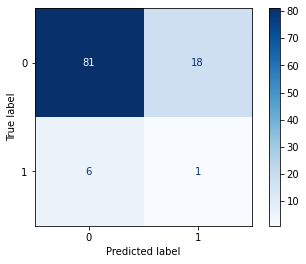

In [133]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

label = ["0", "1"]
cm = confusion_matrix(nus1_y_test, y_pred_nus1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [134]:
test_scaled.groupby('target').count()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
target,,,,,,,,
0.0,99,99,99,99,99,99,99,99
1.0,7,7,7,7,7,7,7,7


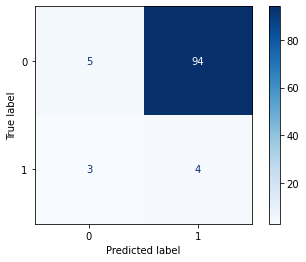

In [135]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

label = ["0", "1"]
cm = confusion_matrix(nus1_y_test, y_pred_org)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# **Accuracy**

In [136]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(nus1_X_train, nus1_y_train)
print('NUS1 Data')
print(knn.score(nus1_X_test, nus1_y_test))

#knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(nus1_org_X_train, nus1_org_y_train)
print('Without NUS!')
print(knn.score(nus1_X_test, nus1_y_test))

NUS1 Data
0.7735849056603774
Without NUS!
0.08490566037735849


In [137]:
f1_score(nus1_y_test, y_pred_nus1, average='macro')

0.47394540942928043

In [138]:
f1_score(nus1_y_test, y_pred_nus1, average='micro')

0.7735849056603775

In [139]:
f1_score(nus1_y_test, y_pred_nus1, average='weighted')

0.8185308300950418

In [140]:
f1_score(nus1_y_test, y_pred_nus1, average=None)

array([0.87096774, 0.07692308])

# **Plot Results**

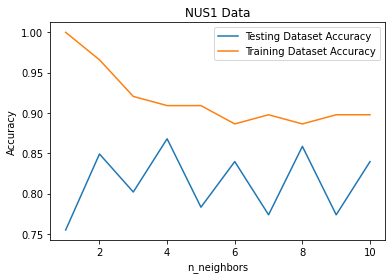

In [141]:
#NUS1 Data
neighbors = np.arange(1,11)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(nus1_X_train, nus1_y_train)
  
  train_accuracy[i] = knn.score(nus1_X_train, nus1_y_train)
  test_accuracy[i] = knn.score(nus1_X_test, nus1_y_test)

plt.plot(neighbors, test_accuracy, label='Testing Dataset Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Dataset Accuracy')

plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('NUS1 Data')
plt.show()

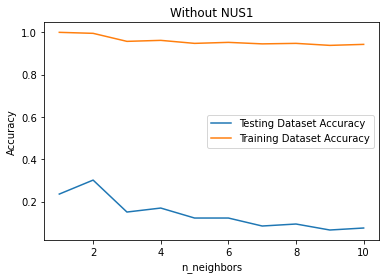

In [142]:
#Original Data (Without NUS1)
neighbors = np.arange(1,11)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(nus1_org_X_train, nus1_org_y_train)
  
  train_accuracy[i] = knn.score(nus1_org_X_train, nus1_org_y_train)
  test_accuracy[i] = knn.score(nus1_X_test, nus1_y_test)

plt.plot(neighbors, test_accuracy, label='Testing Dataset Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Dataset Accuracy')

plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('Without NUS1')
plt.show()